In [39]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import LinExpr
import pandas as pd
import math
import matplotlib.pyplot as plt

from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 10.5,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# 模型来源
# Pickup and delivery problem with time windows: A new compact two-index formulation
## DOI: http://dx.doi.org/10.1016/j.orl.2017.04.013
![图片](img.png)

# 上述模型缺乏服务时间

In [2]:
"""数据读取"""
class Data:#数据类
    def __init__(self):
        self.businessNum = 10 # 商家数量
        self.customerNum = 10 # 客户数量
        self.nodeNum     = 22 # 点数量

        self.capacity    = 80 #车辆容量
        self.cor_X       = [] #x坐标
        self.cor_Y       = [] #y坐标
        self.demand      = [] #客户需求
        self.service_time = [] #服务时间
        self.early_time   = [] #最早时间窗
        self.last_time     = [] #最晚时间窗
        self.disMatrix   = [[]] # 距离矩阵

In [3]:
# 读取数据函数
def readData(data, path):
    df = pd.read_excel(path)
    df.loc[len(df)] = df.iloc[0]

    data.nodeNum = int(len(df))  # 节点数量
    data.businessNum = int((data.nodeNum - 2) /2)
    data.customerNum = data.businessNum # 客户数量

    for i in range(len(df)):
        data.cor_X.append(df['x_coord'][i])
        data.cor_Y.append(df['y_coord'][i])
        data.demand.append(df['demand'][i])
        data.early_time.append(df['early_time'][i])
        data.last_time.append(df['last_time'][i])
        data.service_time.append(df['service_time'][i])

    # 计算距离矩阵
    data.disMatrix = [([0] * data.nodeNum) for _ in range(data.nodeNum)]  # 初始化距离矩阵的维度,防止浅拷贝
    # data.disMatrix = [[0] * nodeNum] * nodeNum]; 这个是浅拷贝，容易重复
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            temp = (data.cor_X[i] - data.cor_X[j]) ** 2 + (data.cor_Y[i] - data.cor_Y[j]) ** 2
            data.disMatrix[i][j] = math.sqrt(temp)

    return data

def printData(data):
    print("下面打印数据\n")
    print("business number = %4d" % data.businessNum)
    print("customer number = %4d" % data.customerNum)
    print("vehicle capacity = %4d" % data.capacity)
    for i in range(len(data.demand)):
        print('{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(data.cor_X[i],data.cor_Y[i],data.demand[i], data.early_time[i], data.last_time[i], data.service_time[i]))
    print("-------距离矩阵-------\n")
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            print("%6.2f" % (data.disMatrix[i][j]), end=" ")#保留2位小数
        print()

In [4]:
# reading data调用上面两个函数
data = Data()
path = r'pdptw_data.xlsx'
readData(data, path)
printData(data)

下面打印数据

business number =   10
customer number =   10
vehicle capacity =   80
40	50	0	0	1236	0
35	69	10	448	505	90
40	69	20	621	702	90
42	66	10	65	146	90
38	70	10	534	605	90
42	65	10	15	67	90
38	68	20	225	324	90
15	75	20	179	254	90
22	75	30	30	92	90
20	85	40	475	528	90
15	80	10	278	345	90
45	68	-10	912	967	90
45	70	-20	825	870	90
45	65	-10	997	1068	90
42	68	-10	727	782	90
40	66	-10	170	225	90
35	66	-20	357	410	90
25	85	-20	652	721	90
18	75	-30	99	148	90
22	85	-40	567	620	90
20	80	-10	384	429	90
40	50	0	0	1236	0
-------距离矩阵-------

  0.00  19.65  19.00  16.12  20.10  15.13  18.11  35.36  30.81  40.31  39.05  18.68  20.62  15.81  18.11  16.00  16.76  38.08  33.30  39.36  36.06   0.00 
 19.65   0.00   5.00   7.62   3.16   8.06   3.16  20.88  14.32  21.93  22.83  10.05  10.05  10.77   7.07   5.83   3.00  18.87  18.03  20.62  18.60  19.65 
 19.00   5.00   0.00   3.61   2.24   4.47   2.24  25.71  18.97  25.61  27.31   5.10   5.10   6.40   2.24   3.00   5.83  21.93  22.80  24.08  22.83  19.00

In [5]:
"""建立模型"""
m = gp.Model('OPDPTW_TWO_INDEX')

In [6]:
"""添加变量"""
# binary--decision variable xijk
x = {}
# vehicle load
Q = {}
# the time that a vehicle starts servicing node i
B = {}
# the index of the first node in the route that visits node
v = {}

# 定义xij
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        x[i,j] = m.addVar(lb=0, ub=1, vtype=GRB.BINARY, name='x[%s,%s]' % (i,j))
# vehicle load
for i in range(data.nodeNum):
    Q[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name='Q[%s]' % i)
#
for i in range(data.nodeNum):
    B[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name='B[%s]' % i)
#
for i in range(data.nodeNum):
    v[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name='v[%s]' % i)

In [7]:
"""更新模型"""
m.update()

In [8]:
"""设置目标函数"""
# 1
obj = LinExpr(0)
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(i != j):
            obj.addTerms(data.disMatrix[i][j], x[i,j])
m.setObjective(obj)

In [9]:
"""添加约束条件"""
P = range(1,data.businessNum+1)
D = range(data.businessNum+1,data.nodeNum-1)
PUD = range(1,data.nodeNum-1)
N = range(data.nodeNum)

In [10]:
# 2 可以
for j in PUD:
    st = LinExpr(0)
    for i in N:
        st.addTerms(1,x[i,j])
    m.addConstr(st==1, name='st1')

In [11]:
# 3 可以 改
for i in PUD:
    st = LinExpr(0)
    # for j in N:
    for j in range(0,data.nodeNum-1):
        st.addTerms(1,x[i,j])
    # m.addConstr(st==1, name='st2')
    m.addConstr(st<=1, name='st2')

In [12]:
# 4 加上服务时间
M = 100000
for i in N:
    for j in N:
        m.addConstr(B[j] >= B[i] + data.disMatrix[i][j] - M * (1 - x[i,j]) + data.service_time[i],name='st3')

In [13]:
# 5
for i in N:
    for j in N:
        m.addConstr(Q[j] >= Q[i] + data.demand[j] - M * (1 - x[i,j]),name='st4')

In [14]:
# 6 使用class会出问题
early_time = [0, 448, 621, 65, 534, 15, 225, 179, 30, 475, 278, 912, 825, 997, 727, 170, 357, 652, 99, 567, 384, 0]
last_time = [1236, 505, 702, 146, 605, 67, 324, 254, 92, 528, 345, 967, 870, 1068, 782, 225, 410, 721, 148, 620, 429, 1236]

for i in N:
    # 报错 GurobiError: Constraint has no bool value (are you trying "lb <= expr <= ub"?)
    # m.addConstr(data.early_time[i] <= B[i], name='early_time')
    m.addConstr(early_time[i] <= B[i], name='early_time')
    m.addConstr(B[i] <= last_time[i] , name='last_time')

In [15]:
# 7
demand = [0, 10, 20, 10, 10, 10, 20, 20, 30, 40, 10, -10, -20, -10, -10, -10, -20, -20, -30, -40, -10, 0]

for i in N:
    m.addConstr(max(0,demand[i]) <= Q[i], name='R7')
    m.addConstr(Q[i] <= min(data.capacity,data.capacity+demand[i]), name='R8')

In [16]:
# 8 加上服务时间
for i in P:
    m.addConstr(B[data.businessNum+i] >= B[i] + data.disMatrix[i][data.businessNum+i] + data.service_time[i])

In [17]:
# 9
for i in P:
    m.addConstr(v[data.businessNum+i] == v[i])

In [18]:
# 10
for j in PUD:
    m.addConstr(v[j] >= j * x[0,j])

In [19]:
# 11
for j in PUD:
    m.addConstr(v[j] <= j * x[0,j] - data.businessNum * (x[0,j] - 1))

In [20]:
# 12
for i in PUD:
    for j in PUD:
        m.addConstr(v[j] >= v[i] + data.businessNum * (x[i,j] - 1))

In [21]:
# 13
for i in PUD:
    for j in PUD:
        m.addConstr(v[j] <= v[i] + data.businessNum * (1 - x[i,j]))

In [22]:
# 14 不回0点
lhs = LinExpr(0)
for j in PUD:
    lhs.addTerms(1, x[j, 0])
m.addConstr(lhs == 0)

<gurobi.Constr *Awaiting Model Update*>

In [23]:
# 任意车辆不从仓库到仓库
# m.addConstr(x[0, data.nodeNum - 1] == 0)

In [24]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1957 rows, 550 columns and 6223 nonzeros
Model fingerprint: 0xb89d41be
Variable types: 66 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 360.0216483
Presolve removed 1910 rows and 457 columns
Presolve time: 0.02s
Presolved: 47 rows, 93 columns, 233 nonzeros
Found heuristic solution: objective 164.0789424
Variable types: 5 continuous, 88 integer (85 binary)
Found heuristic solution: objective 133.9678719

Root relaxation: objective 1.016125e+02, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

In [25]:
print("\n\n-----optimal value-----")
print(m.ObjVal)



-----optimal value-----
101.6125328427624


In [26]:
for key in x.keys():
    if(x[key].x > 0 ):
        print(x[key].VarName + ' = ', x[key].x)

x[1,4] =  1.0
x[2,14] =  1.0
x[3,15] =  1.0
x[4,2] =  1.0
x[5,3] =  1.0
x[6,16] =  1.0
x[7,10] =  1.0
x[8,18] =  1.0
x[9,19] =  1.0
x[10,20] =  1.0
x[11,13] =  1.0
x[12,11] =  1.0
x[14,12] =  1.0
x[15,6] =  1.0
x[16,1] =  1.0
x[18,7] =  1.0
x[19,17] =  1.0
x[20,9] =  1.0
x[21,5] =  1.0
x[21,8] =  1.0


In [27]:
"""结果处理"""
'''字符转为list'''
zifu = []
for key in x.keys():
    if (x[key].x > 0):
        zifu.append(x[key].VarName)
zifu.sort()
print(zifu)

'''提取数字'''
import re
fenge = [([]) for i in range(data.nodeNum-2)]
for char in range(data.nodeNum-2):
    a = zifu[char]
    number = list(filter(str.isdigit, a))
    fenge[char] = re.findall(r"\d+\.?\d*", a)
print('提取数字',fenge)

['x[1,4]', 'x[10,20]', 'x[11,13]', 'x[12,11]', 'x[14,12]', 'x[15,6]', 'x[16,1]', 'x[18,7]', 'x[19,17]', 'x[2,14]', 'x[20,9]', 'x[21,5]', 'x[21,8]', 'x[3,15]', 'x[4,2]', 'x[5,3]', 'x[6,16]', 'x[7,10]', 'x[8,18]', 'x[9,19]']
提取数字 [['1', '4'], ['10', '20'], ['11', '13'], ['12', '11'], ['14', '12'], ['15', '6'], ['16', '1'], ['18', '7'], ['19', '17'], ['2', '14'], ['20', '9'], ['21', '5'], ['21', '8'], ['3', '15'], ['4', '2'], ['5', '3'], ['6', '16'], ['7', '10'], ['8', '18'], ['9', '19']]


In [28]:
import copy
routes = []

num = copy.deepcopy(fenge)
for fen in fenge:
    if fen[0] == '21':
        routes.append(fen)
        num.remove(fen)


In [29]:
routes

[['21', '5'], ['21', '8']]

In [30]:
num

[['1', '4'],
 ['10', '20'],
 ['11', '13'],
 ['12', '11'],
 ['14', '12'],
 ['15', '6'],
 ['16', '1'],
 ['18', '7'],
 ['19', '17'],
 ['2', '14'],
 ['20', '9'],
 ['3', '15'],
 ['4', '2'],
 ['5', '3'],
 ['6', '16'],
 ['7', '10'],
 ['8', '18'],
 ['9', '19']]

In [31]:
check = []
for a in range(len(num)):
    check.append(num[a][0])
check

['1',
 '10',
 '11',
 '12',
 '14',
 '15',
 '16',
 '18',
 '19',
 '2',
 '20',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [32]:
for route in routes:
    i = 1
    j = 0
    n = len(num)
    while j <= n:
        if route[i] == num[j][0]:
            route.append(num[j][1])
            # num.remove(num[j])
            i += 1
            j = 0
        else:
            j += 1
        if route[i] not in check:
            break
    print(route)

['21', '5', '3', '15', '6', '16', '1', '4', '2', '14', '12', '11', '13']
['21', '8', '18', '7', '10', '20', '9', '19', '17']


In [33]:
routes[0] = [int(x) for x in routes[0]]
routes[1] = [int(x) for x in routes[1]]

In [34]:
routes

[[21, 5, 3, 15, 6, 16, 1, 4, 2, 14, 12, 11, 13],
 [21, 8, 18, 7, 10, 20, 9, 19, 17]]

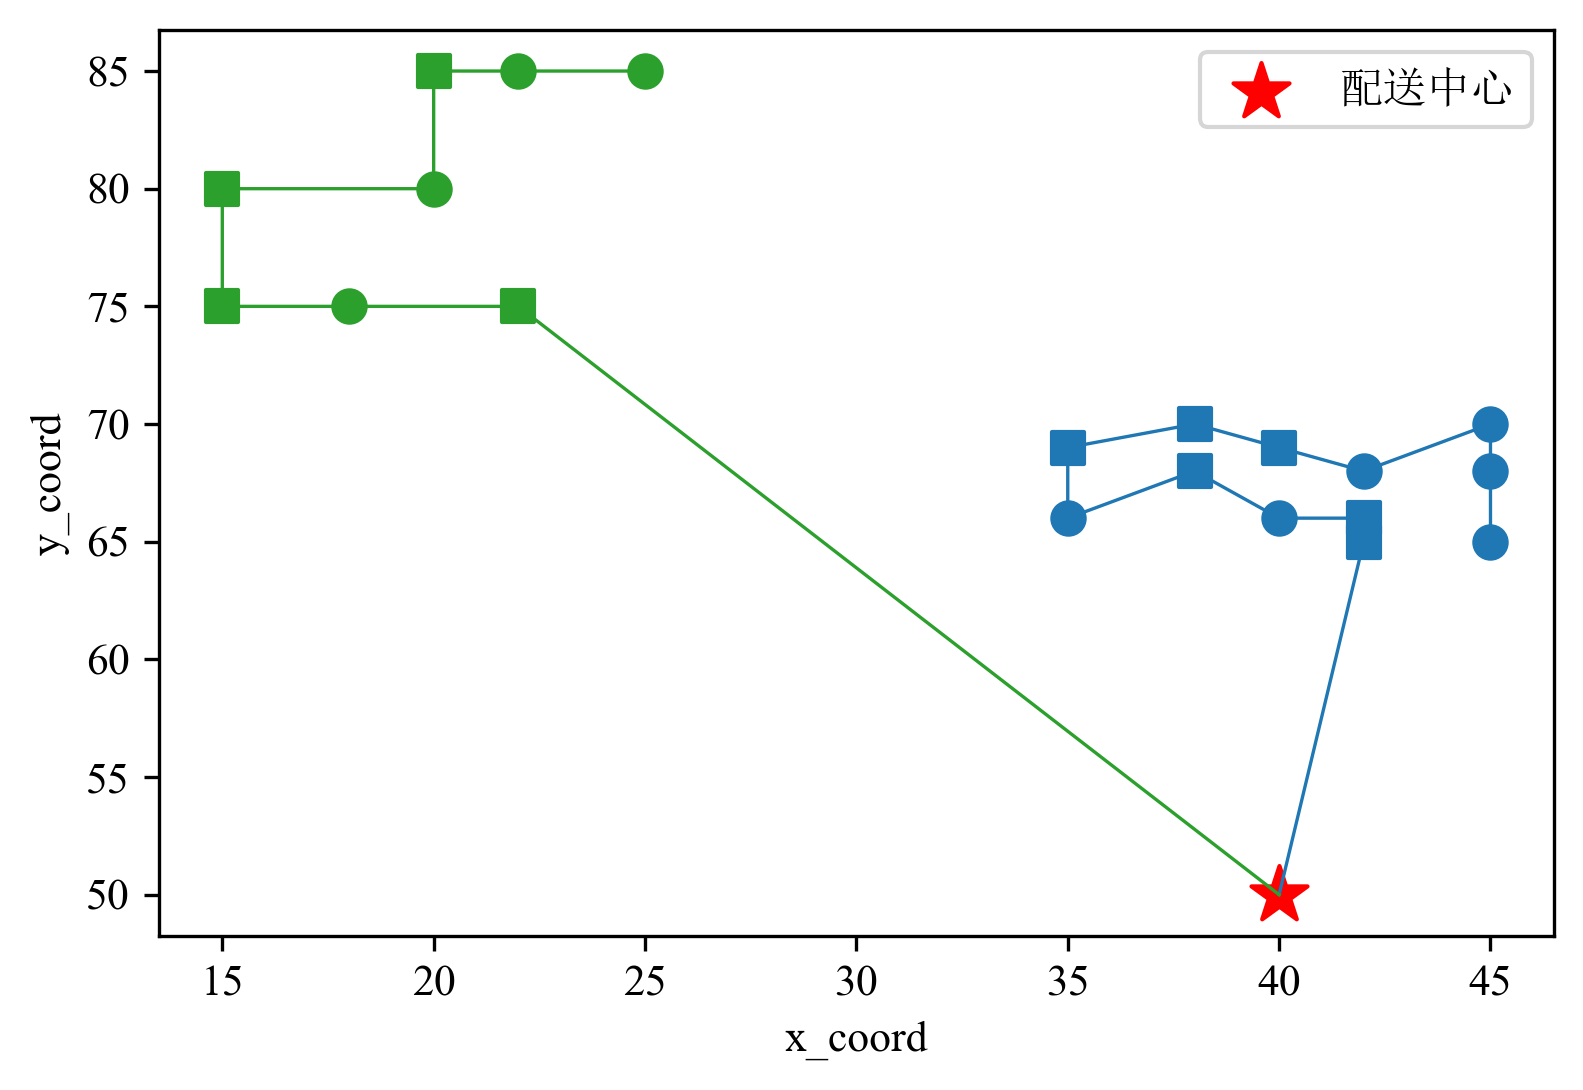

In [43]:
'''画图'''
plt.figure(dpi=300)

x1,y1 = [],[]
for i in routes[0]:
    x1.append(data.cor_X[i])
    y1.append(data.cor_Y[i])
    if 21 > i > data.businessNum:
        mark = 'o'
    else:
        mark = 's'
    if 0< i < 21:
        plt.scatter(data.cor_X[i],data.cor_Y[i],marker=mark,color='tab:blue',s=60)

plt.plot(x1,y1,linewidth=0.8,color='tab:blue')

x2,y2 = [],[]
for i in routes[1]:
    x2.append(data.cor_X[i])
    y2.append(data.cor_Y[i])
    if 21 > i > data.businessNum:
        mark = 'o'
    else:
        mark = 's'

    if 0< i < 21:
        plt.scatter(data.cor_X[i],data.cor_Y[i],marker=mark,color='tab:green',s=60)

plt.plot(x2,y2,linewidth=0.8,color='tab:green')

plt.scatter(data.cor_X[0],data.cor_Y[0],marker='*',color='red',s=200,label='配送中心')
plt.xticks(fontproperties='Times New Roman')
plt.yticks(fontproperties='Times New Roman')
plt.xlabel('x_coord', fontproperties='Times New Roman')
plt.ylabel('y_coord', fontproperties='Times New Roman')
plt.legend()